In [1]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
    cdict,
    reset_plot_styles,
)
from deq2ff.plotting.dashboard import (
    get_runs_from_wandb,
    filter_best_runs,
    mark_sota,
    add_best_run,
    preprocess_df,
    print_table_acc_time,
    plot_acc_vs_speed,
    plot_acc_vs_speed_errorbar,
    norm_targets,
    print_table_acc,
    get_keys_history,
    plot_loss_curve,
)


nans = ["NaN", pd.NA, None, float("inf"), np.nan]

# OC20

In [2]:
# Config
project = projectoc

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val,
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

In [3]:
if project == projectoc:
    tag = "depthoc"
    fname = "depthocv1"
else:
    tag = "depthmd"
    fname = "depthmdv1"

dfdepth = get_runs_from_wandb(
    project=project,
    download_data=True,
    filters={
        "tags": tag,
        # "$and": [{"tags": "md17"}, {"tags": "eval"}],
        # "state": "finished",
        # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
        "state": "finished",
        # "$or": [{"state": "finished"}, {"state": "crashed"}],
    },
    fname="depth" + fname,
)
print(f"Found {len(dfdepth)} of 8+2 runs")

dfdepth = preprocess_df(df=dfdepth, project=project, error_metric=error_metric)

Found 16 runs:
Saved dataframe.
Found 16 of 8+2 runs
before filter: 16
after filter: 16
replacing 10/16 0's with 200k
Adding optim.max_epochs to target


In [4]:
dfdepth = mark_sota(dfdepth, error_metric=error_metric)


Models: ['E4' 'DEQ1' 'E6' 'E1' 'E2' 'E3' 'E7' 'E5' 'E8' 'DEQ2' 'E9' 'E10' 'E11'
 'E12' 'E13' 'E14']


In [5]:

table = print_table_acc(
    df=dfdepth, # df_best_runs, df_alt
    dnames=["oc20"],
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    corner="OC20 200k",
)

\begin{tabular}{lc}
\toprule[1.2pt]
OC20 200k & Force \\
\midrule[1.2pt]
\equiformer{} (1 layer) & $0.052$ \\
\equiformer{} (4 layers) & $0.045$ \\
\equiformer{} (8 layers) & $0.045$ \\
\midrule[0.6pt]
DEQ (1 layer) & $\mathbf{0.043}$ \\
DEQ (2 layers) & $\mathbf{0.042}$ \\


Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_depth_oc.png


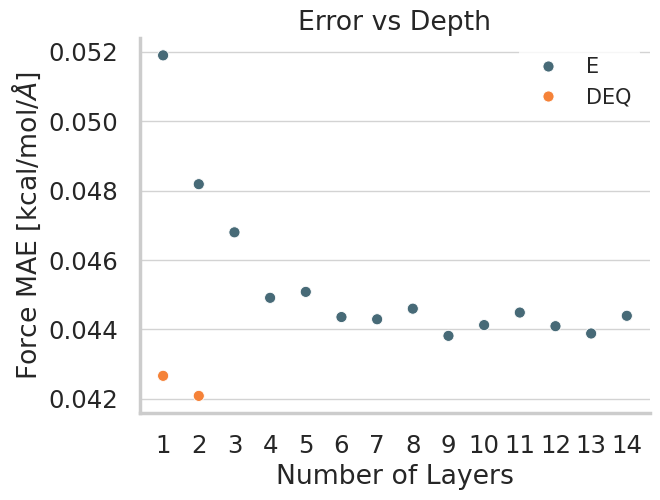

In [6]:
# plot acc over depth

y = error_metric
x = "config.model.num_layers"
hue = "Class"
data = dfdepth.copy()

# plot
reset_plot_styles()
set_seaborn_style(palette="deep")

fig, ax = plt.subplots()
sns.scatterplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    ax=ax,
    palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
# vertical xtick labels
# plt.xticks(rotation=90)
plt.title("Error vs Depth")

num_layers = data[x].unique().max()

# set xticks 1, 2, 3, 4, 5, 6, 7, 8
plt.xticks(np.arange(1, num_layers+1, 1))

# plt.xlim(0.5, 8.5)

# horizontal grid
plt.grid(axis="y")

set_style_after(ax=ax)

# save
fname = "acc_vs_depth_oc"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()

In [7]:
# [c for c in dfdepth.keys() if ("summary" in c) and ("gradients" not in c)]

Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/acc_vs_params_oc.png


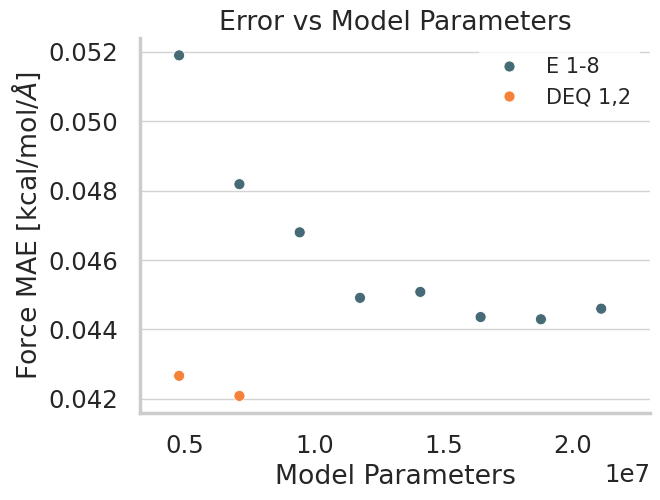

In [8]:
# Accuracy over model parameters
#  “summary.ModelParameters”

y = error_metric
# x = "config.model.num_layers"
x = "summary.ModelParameters"
data = dfdepth.copy()

hue = "Model"
data["Model"] = data["Model"].apply(lambda x: "E 1-8" if "DEQ" not in x else x)
data["Model"] = data["Model"].apply(lambda x: "DEQ 1,2" if "DEQ" in x else x)

# plot
reset_plot_styles()
set_seaborn_style(palette="deep")

fig, ax = plt.subplots()
sns.scatterplot(
    x=x,
    y=y,
    hue=hue,
    data=data,
    ax=ax,
    palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
# vertical xtick labels
# plt.xticks(rotation=90)
plt.title("Error vs Model Parameters")

# horizontal grid
plt.grid(axis="y")

plt.xlim(right=2.3e7)


set_style_after(ax=ax)

# save
fname = "acc_vs_params_oc"
plt.savefig(f"{plotfolder}/{fname}.png")
print(f"Saved plot to \n {plotfolder}/{fname}.png")
plt.show()

## Train / Val loss curves


run_id: qdpqubnn
name:   pDEQs apc reg
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_qdpqubnn_pDEQsapcreg.parquet

run_id: 51v5zb2e
name:   pDEQs apc numlayers-2 reg
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_51v5zb2e_pDEQsapcnumlayers2reg.parquet

run_id: 55rg8ada
name:   pEs dd numlayers-1 reg
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_55rg8ada_pEsddnumlayers1reg.parquet

run_id: j4ub57rb
name:   pEs dd reg
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_j4ub57rb_pEsddreg.parquet

run_id: hh021723
name:   pEs dd numlayers-8 reg
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_hh021723_pEsddnumlayers8reg.parquet
df: 750000
Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/test_loss_oc20.png


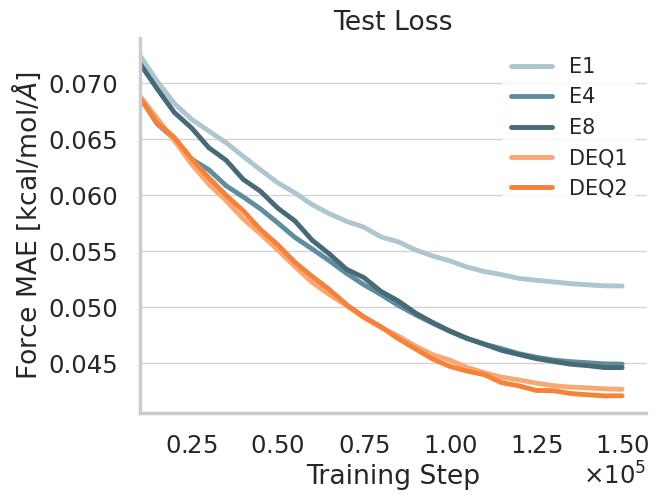

In [9]:
# train / val loss OC20
_project = projectoc

# pDEQs apc reg qdpqubnn
# pDEQs apc numlayers-2 reg 51v5zb2e
# pEs dd numlayers-1 reg 55rg8ada
# pEs dd reg j4ub57rb
# pEs dd numlayers-8 reg hh021723

keys = ["train/forces_mae", "val/forces_mae"]
dfq1 = get_keys_history("qdpqubnn", project=_project, keys=keys)
dfq2 = get_keys_history("51v5zb2e", project=_project, keys=keys)
dfe1 = get_keys_history("55rg8ada", project=_project, keys=keys)
dfe4 = get_keys_history("j4ub57rb", project=_project, keys=keys)
dfe8 = get_keys_history("hh021723", project=_project, keys=keys)

# combine into one dataframe
dftrainoc = pd.concat([dfe1, dfe4, dfe8, dfq1, dfq2])
dftrainoc["Model"] = dftrainoc["Class"] + dftrainoc["model.num_layers"].astype(str)
print('df:', len(dftrainoc))

# fig, ax = plot_loss_curve(
#     df=dftrainoc, y="train/forces_mae", 
#     xlabel="Training Step", ylabel=human_labels("test_f_mae"),
#     xmin=10000,
#     hue="Model",
#     palette=cdict,
#     title="Training Loss",
#     fname="training_loss_oc20",
# )
# plt.show()

fig, ax = plot_loss_curve(
    df=dftrainoc, y="val/forces_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=10000,
    hue="Model",
    palette=cdict,
    title="Test Loss",
    fname="test_loss_oc20",
)
plt.show()


Saved plot to 
 /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/training_loss_oc20_smooth.png


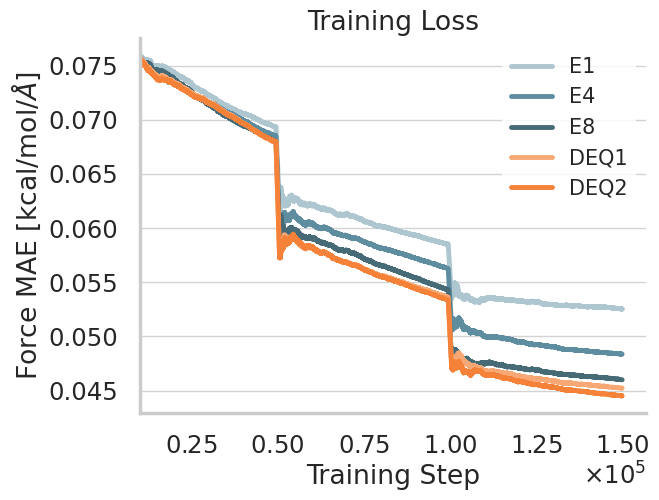

: 

In [10]:
# remove spike in train loss around epoch change
_dfc = dftrainoc.copy()
minstep = 10000
_dfc = _dfc[_dfc["_step"] > minstep]

# iterations = 2
# for i in range(iterations):
#     # index of max train loss
#     idx = _dfc["train/forces_mae"].idxmax()
#     print("idx", idx, _dfc.iloc[idx]["train/forces_mae"])
#     stepmax = _dfc.iloc[idx]["_step"]
#     print("stepmax", stepmax, _dfc[_dfc["_step"] == stepmax]["train/forces_mae"])

#     # remove +- 5 steps using index
#     _dfc = _dfc.drop(index=range(idx-10, idx+10))

#     # remove +- 5 steps using stepmax
#     # _dfc = _dfc[(_dfc["_step"] > stepmax + 5) | (_dfc["_step"] < stepmax - 5)]
#     # _dfc = _dfc[(_dfc["_step"] > stepmax + 5)]
#     # _dfc = _dfc[(_dfc["_step"] < stepmax - 5)]
#     # _dfc = _dfc[(_dfc["_step"] < idx - 5)]

# epochborder = 0.5e5
for epochborder in [0.5e5, 1e5]:
    _dfc = _dfc[(_dfc["_step"] > epochborder + 500) | (_dfc["_step"] < epochborder - 500)]

fig, ax = plot_loss_curve(
    df=_dfc, y="train/forces_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=minstep,
    hue="Model",
    palette=cdict,
    title="Training Loss",
    fname="training_loss_oc20_smooth",
)
plt.show()

### long training

In [11]:
# train / val loss OC20
_project = projectoc

# pDEQs apc reg qdpqubnn
# pDEQs apc numlayers-2 reg 51v5zb2e
# pEs dd numlayers-1 reg 55rg8ada
# pEs dd reg j4ub57rb
# pEs dd numlayers-8 reg hh021723

keys = ["train/forces_mae", "val/forces_mae"]
dfq1 = get_keys_history("w40yrw1f", project=_project, keys=keys)
dfq12 = get_keys_history("1mdsm2tv", project=_project, keys=keys)
dfq13 = get_keys_history("10kzfvnb", project=_project, keys=keys)
dfq14 = get_keys_history("427qpwk2", project=_project, keys=keys)
# dfq2 = get_keys_history("51v5zb2e", project=_project, keys=keys)
dfe1 = get_keys_history("o1hhn8lw", project=_project, keys=keys)
dfe4 = get_keys_history("kuirhk66", project=_project, keys=keys)
dfe8 = get_keys_history("12e8n8q4", project=_project, keys=keys)

# combine into one dataframe
dftrainoc = pd.concat([dfe1, dfe4, dfe8, dfq1, dfq12, dfq13, dfq14])
dftrainoc["Model"] = dftrainoc["Class"] + dftrainoc["model.num_layers"].astype(str)
print('df:', len(dftrainoc))

# fig, ax = plot_loss_curve(
#     df=dftrainoc, y="train/forces_mae", 
#     xlabel="Training Step", ylabel=human_labels("test_f_mae"),
#     xmin=10000,
#     hue="Model",
#     palette=cdict,
#     title="Training Loss",
#     fname="training_loss_oc20",
# )
# plt.show()

fig, ax = plot_loss_curve(
    df=dftrainoc, y="val/forces_mae", 
    xlabel="Training Step", ylabel=human_labels("test_f_mae"),
    xmin=10000,
    hue="Model",
    palette=cdict,
    title="Test Loss",
    fname="test_loss_oc20_10epochs",
)
plt.show()



run_id: w40yrw1f
name:   pDEQs ap optimmaxepochs-10 reg


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:1385: DtypeWarning: Columns (44,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sname)


Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_w40yrw1f_pDEQsapoptimmaxepochs10reg.parquet

run_id: 1mdsm2tv
name:   pDEQs ap optimmaxepochs-10 reg


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:1385: DtypeWarning: Columns (1,4,5,6,8,9,11,13,14,15,18,19,20,22,23,24,25,26,27,29,31,32,35,37,38,39,40,41,44,46,47,51,54,55,59,65,66,68,71,74,77,78,79,81,83,86,87,88,89,90,91,92,93,96,98,99,101,102,103,104,105,106,107,109,110,113,114,116,117,118,119,120,122,123,125,127,128,131,132,133,134,135,136,140,141,143,145,146,147,148,152,153,155) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sname)


Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_1mdsm2tv_pDEQsapoptimmaxepochs10reg.parquet

run_id: 10kzfvnb
name:   pDEQs ap optimmaxepochs-10 reg


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:1385: DtypeWarning: Columns (60,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sname)


Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_10kzfvnb_pDEQsapoptimmaxepochs10reg.parquet

run_id: 427qpwk2
name:   pDEQs ap optimmaxepochs-10 reg


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:1385: DtypeWarning: Columns (21,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(sname)


Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_427qpwk2_pDEQsapoptimmaxepochs10reg.parquet

run_id: o1hhn8lw
name:   pEs dd numlayers-1 optimmaxepochs-10 reg
Loaded from csv: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_o1hhn8lw_pEsddnumlayers1optimmaxepochs10reg.parquet

run_id: kuirhk66
name:   pEs dd optimmaxepochs-10 reg
File not found: /ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/plots/traintestfmae_kuirhk66_pEsddoptimmaxepochs10reg.parquet
History: <class 'wandb.apis.public.history.HistoryScan'>
